# Video Game Recommender System Notebook

In this notebook, we look at how we can create a recommender system for video games using content based techniques. 
Content based recommmenders use items to recommend other items. 
Adavantages :
- No knowledge about the user is required.
- No cold start
Disadvantages:


## Output
The goal of this project is to build a recommender system for video games and then deploy it as a Streamlit app while applying MLOps methodology. 
- Fully automated processes.
- CI/CD using GitHub Actions.
- include test using Pytest.
- Feature store with the saved distances and indices.


In [1]:
#load the necessary libraries
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
np.random.seed(0)

In [3]:
#download the dataset from kaggle

import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadadiltalay/imdb-video-games")

print("Path to dataset files:", path)



/Users/thibtd/some fun/video games recommender/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/thibtd/.cache/kagglehub/datasets/muhammadadiltalay/imdb-video-games/versions/1


### EDA 
Let's have a look at our data

In [4]:
#Load the dataset
df = pd.read_csv(path+"/imdb-videogames.csv" ,index_col='Unnamed: 0')

In [5]:
df.head()

,name,url,year,certificate,rating,votes,plot,Action,Adventure,Comedy,Crime,Family,Fantasy,Mystery,Sci-Fi,Thriller
0,Spider-Man,https://www.imdb.com/title/tt5807780/?ref_=adv...,2018.0,T,9.2,"20,759","When a new villain threatens New York City, Pe...",True,True,False,False,False,True,False,False,False
1,Red Dead Redemption II,https://www.imdb.com/title/tt6161168/?ref_=adv...,2018.0,M,9.7,"35,703",Amidst the decline of the Wild West at the tur...,True,True,False,True,False,False,False,False,False
2,Grand Theft Auto V,https://www.imdb.com/title/tt2103188/?ref_=adv...,2013.0,M,9.5,"59,986",Three very different criminals team up for a s...,True,False,False,True,False,False,False,False,False
3,God of War,https://www.imdb.com/title/tt5838588/?ref_=adv...,2018.0,M,9.6,"26,118","After wiping out the gods of Mount Olympus, Kr...",True,True,False,False,False,False,False,False,False
4,Uncharted 4: A Thief's End,https://www.imdb.com/title/tt3334704/?ref_=adv...,2016.0,T,9.5,"28,722",Thrown back into the dangerous underworld he'd...,True,True,False,False,False,False,False,False,False


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20803 entries, 0 to 20802
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         20803 non-null  object 
 1   url          20803 non-null  object 
 2   year         20536 non-null  float64
 3   certificate  7903 non-null   object 
 4   rating       11600 non-null  float64
 5   votes        11600 non-null  object 
 6   plot         20803 non-null  object 
 7   Action       20803 non-null  bool   
 8   Adventure    20803 non-null  bool   
 9   Comedy       20803 non-null  bool   
 10  Crime        20803 non-null  bool   
 11  Family       20803 non-null  bool   
 12  Fantasy      20803 non-null  bool   
 13  Mystery      20803 non-null  bool   
 14  Sci-Fi       20803 non-null  bool   
 15  Thriller     20803 non-null  bool   
dtypes: bool(9), float64(2), object(5)
memory usage: 1.4+ MB


The dataset contains 15 columns including different genres, year of realease, rating and a description of the plot.
There are a total of 20803.

In [7]:
df.describe()

,year,rating
count,20536.000000,11600.000000
mean,2005.568611,7.047526
std,11.846028,1.235204
min,1952.000000,1.000000
25%,1997.000000,6.400000
50%,2008.000000,7.200000
75%,2016.000000,7.900000
max,2027.000000,9.700000


Let's remove the duplicated names and games with missing year of realease

In [8]:
df['year'].isna().sum()

np.int64(267)

In [9]:
df.dropna(subset=["year"], inplace=True) 

In [10]:
df['name'].duplicated().sum()

np.int64(1081)

In [11]:
df.drop_duplicates(subset=['name'], inplace=True)

In [12]:
df.head()

,name,url,year,certificate,rating,votes,plot,Action,Adventure,Comedy,Crime,Family,Fantasy,Mystery,Sci-Fi,Thriller
0,Spider-Man,https://www.imdb.com/title/tt5807780/?ref_=adv...,2018.0,T,9.2,"20,759","When a new villain threatens New York City, Pe...",True,True,False,False,False,True,False,False,False
1,Red Dead Redemption II,https://www.imdb.com/title/tt6161168/?ref_=adv...,2018.0,M,9.7,"35,703",Amidst the decline of the Wild West at the tur...,True,True,False,True,False,False,False,False,False
2,Grand Theft Auto V,https://www.imdb.com/title/tt2103188/?ref_=adv...,2013.0,M,9.5,"59,986",Three very different criminals team up for a s...,True,False,False,True,False,False,False,False,False
3,God of War,https://www.imdb.com/title/tt5838588/?ref_=adv...,2018.0,M,9.6,"26,118","After wiping out the gods of Mount Olympus, Kr...",True,True,False,False,False,False,False,False,False
4,Uncharted 4: A Thief's End,https://www.imdb.com/title/tt3334704/?ref_=adv...,2016.0,T,9.5,"28,722",Thrown back into the dangerous underworld he'd...,True,True,False,False,False,False,False,False,False


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19455 entries, 0 to 20802
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         19455 non-null  object 
 1   url          19455 non-null  object 
 2   year         19455 non-null  float64
 3   certificate  7133 non-null   object 
 4   rating       10657 non-null  float64
 5   votes        10657 non-null  object 
 6   plot         19455 non-null  object 
 7   Action       19455 non-null  bool   
 8   Adventure    19455 non-null  bool   
 9   Comedy       19455 non-null  bool   
 10  Crime        19455 non-null  bool   
 11  Family       19455 non-null  bool   
 12  Fantasy      19455 non-null  bool   
 13  Mystery      19455 non-null  bool   
 14  Sci-Fi       19455 non-null  bool   
 15  Thriller     19455 non-null  bool   
dtypes: bool(9), float64(2), object(5)
memory usage: 1.4+ MB


We are now left with 19714 different games, let's now explore the different certificates.

In [14]:
# count number of plot with text == 'Add a Plot'
df['plot'].value_counts()['Add a Plot']
# drop rows with plot == 'Add a Plot'
df = df[df['plot'] != 'Add a Plot']

In [15]:
df.shape

(10946, 16)

In [16]:
df['certificate']= df.certificate.fillna('Not Rated')

In [17]:
df.certificate.unique()

array(['T', 'M', 'E10+', 'E', 'Not Rated', 'Unrated', 'AO', 'K-A', 'GA',
       '12', 'TV-14', 'MA-13', 'PG-13', 'Approved', 'MA-17', 'PG', 'EC',
       'G', 'CE', 'Passed', 'TV-MA'], dtype=object)

Based on the country, different rating systems are useed to certify the age limit for a game. Yielding to a vast range of different certifcates values. (https://en.wikipedia.org/wiki/Video_game_content_rating_system#Rating_systems)
This is what we have here, thus we will map all the different categories to the ESRB system in order to limit the amount of categories we have and make sure that they convey the same information. (https://www.esrb.org/ratings-guide/)

In [18]:
df['certificate'] = df.certificate.replace({'K-A':'E', 'EC':'E','GA':'E', 'CE':'T', '12':'T','PG-13':'T','MA-13':'T','G':'E', 'MA-17':'M','PG':'E','TV-MA':'M','TV-14':'T','Unrated':'Not Rated','Passed':'Not Rated','Approved':'Not Rated'})

(array([1842.,    0., 1343.,    0.,  622.,    0., 1600.,    0., 5509.,
          30.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

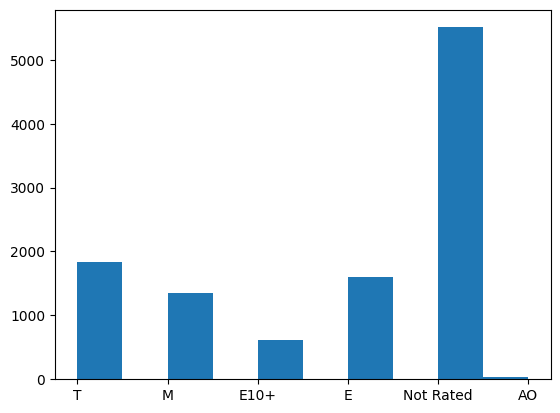

In [19]:
# NBVAL_IGNORE_OUTPUT
plt.hist(df.certificate.astype("category"))

Most of the games are Not Rated.

(array([1.000e+00, 1.000e+00, 1.200e+01, 9.800e+01, 5.270e+02, 1.567e+03,
        2.308e+03, 2.100e+03, 3.247e+03, 1.085e+03]),
 array([1952. , 1959.5, 1967. , 1974.5, 1982. , 1989.5, 1997. , 2004.5,
        2012. , 2019.5, 2027. ]),
 <BarContainer object of 10 artists>)

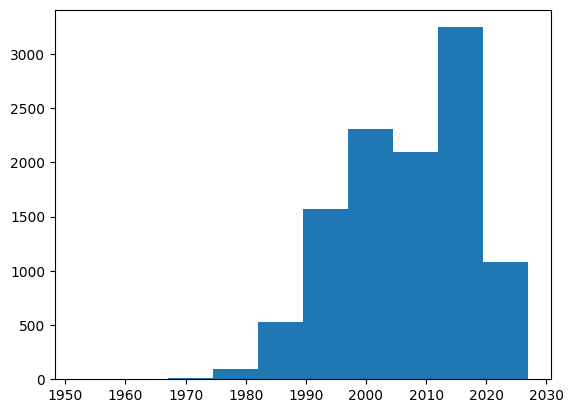

In [20]:
plt.hist(df.year)

Looking at the year of release, we can see that the number of games released each year increases continuously with a large increse in the mid/late 2010s.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10946 entries, 0 to 20802
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         10946 non-null  object 
 1   url          10946 non-null  object 
 2   year         10946 non-null  float64
 3   certificate  10946 non-null  object 
 4   rating       8022 non-null   float64
 5   votes        8022 non-null   object 
 6   plot         10946 non-null  object 
 7   Action       10946 non-null  bool   
 8   Adventure    10946 non-null  bool   
 9   Comedy       10946 non-null  bool   
 10  Crime        10946 non-null  bool   
 11  Family       10946 non-null  bool   
 12  Fantasy      10946 non-null  bool   
 13  Mystery      10946 non-null  bool   
 14  Sci-Fi       10946 non-null  bool   
 15  Thriller     10946 non-null  bool   
dtypes: bool(9), float64(2), object(5)
memory usage: 780.3+ KB


Limit the data to only released games

In [22]:
df_2024 = df[df['year']<=2024].reset_index(drop=True)

In [23]:
df_2024

,name,url,year,certificate,rating,votes,plot,Action,Adventure,Comedy,Crime,Family,Fantasy,Mystery,Sci-Fi,Thriller
0,Spider-Man,https://www.imdb.com/title/tt5807780/?ref_=adv...,2018.0,T,9.2,"20,759","When a new villain threatens New York City, Pe...",True,True,False,False,False,True,False,False,False
1,Red Dead Redemption II,https://www.imdb.com/title/tt6161168/?ref_=adv...,2018.0,M,9.7,"35,703",Amidst the decline of the Wild West at the tur...,True,True,False,True,False,False,False,False,False
2,Grand Theft Auto V,https://www.imdb.com/title/tt2103188/?ref_=adv...,2013.0,M,9.5,"59,986",Three very different criminals team up for a s...,True,False,False,True,False,False,False,False,False
3,God of War,https://www.imdb.com/title/tt5838588/?ref_=adv...,2018.0,M,9.6,"26,118","After wiping out the gods of Mount Olympus, Kr...",True,True,False,False,False,False,False,False,False
4,Uncharted 4: A Thief's End,https://www.imdb.com/title/tt3334704/?ref_=adv...,2016.0,T,9.5,"28,722",Thrown back into the dangerous underworld he'd...,True,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10939,Bite Marks,https://www.imdb.com/title/tt2797224/?ref_=adv...,2012.0,Not Rated,NaN,NaN,A demonologist gets in over his head while mak...,False,False,False,False,False,False,False,False,False
10940,RedSun2020,https://www.imdb.com/title/tt0790739/?ref_=adv...,2004.0,Not Rated,NaN,NaN,Joseph gets kidnapped and it's the player's jo...,False,False,False,False,False,False,False,False,True
10941,Shutter,https://www.imdb.com/title/tt5119948/?ref_=adv...,2015.0,Not Rated,NaN,NaN,A tech support man who uses a drone to investi...,False,False,False,False,False,False,False,False,True
10942,The Music Machine,https://www.imdb.com/title/tt5142082/?ref_=adv...,2015.0,Not Rated,NaN,NaN,A young teenage girl and the ghost of a dead m...,False,False,False,False,False,False,False,False,True


In [24]:
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10944 entries, 0 to 10943
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         10944 non-null  object 
 1   url          10944 non-null  object 
 2   year         10944 non-null  float64
 3   certificate  10944 non-null  object 
 4   rating       8022 non-null   float64
 5   votes        8022 non-null   object 
 6   plot         10944 non-null  object 
 7   Action       10944 non-null  bool   
 8   Adventure    10944 non-null  bool   
 9   Comedy       10944 non-null  bool   
 10  Crime        10944 non-null  bool   
 11  Family       10944 non-null  bool   
 12  Fantasy      10944 non-null  bool   
 13  Mystery      10944 non-null  bool   
 14  Sci-Fi       10944 non-null  bool   
 15  Thriller     10944 non-null  bool   
dtypes: bool(9), float64(2), object(5)
memory usage: 694.8+ KB


In [25]:
urls= df_2024['url']
df_2024.drop(['url','votes'],axis=1, inplace=True)

In [26]:
print(urls)

0        https://www.imdb.com/title/tt5807780/?ref_=adv...
1        https://www.imdb.com/title/tt6161168/?ref_=adv...
2        https://www.imdb.com/title/tt2103188/?ref_=adv...
3        https://www.imdb.com/title/tt5838588/?ref_=adv...
4        https://www.imdb.com/title/tt3334704/?ref_=adv...
                               ...                        
10939    https://www.imdb.com/title/tt2797224/?ref_=adv...
10940    https://www.imdb.com/title/tt0790739/?ref_=adv...
10941    https://www.imdb.com/title/tt5119948/?ref_=adv...
10942    https://www.imdb.com/title/tt5142082/?ref_=adv...
10943    https://www.imdb.com/title/tt10964974/?ref_=ad...
Name: url, Length: 10944, dtype: object


In [27]:
df_2024['rating'].median()

np.float64(7.3)

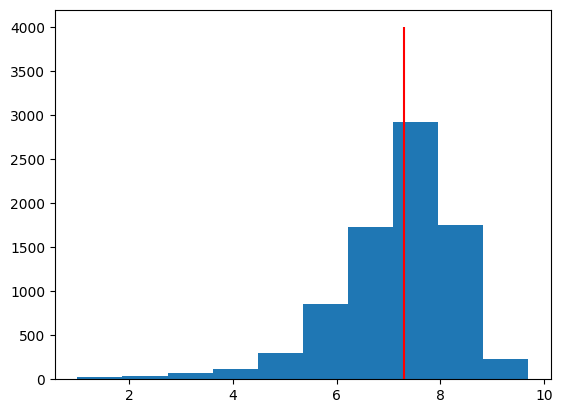

In [28]:
# NBVAL_IGNORE_OUTPUT
fig = plt.figure()
plt.hist(df_2024.rating)
plt.vlines(df_2024['rating'].median(), ymin=0, ymax= 4000, color='red')

Here we can see that the median rating of the games is 7.2. So 50% of the games have a worse than 7.2 rating and 50% have a higher rating.

In [29]:
median = df_2024['rating'].median()
df_2024['rating'] = df_2024['rating'].fillna(median)

### Feature Egineering

1. We have text data for the plots. As is it is not gonna be helpful for our model but we can use Tf-idf to transform our texts into meaningful information that will help our model link games together based on their plots. 

In [30]:
game_plots = df_2024['plot']
game_plots

0        When a new villain threatens New York City, Pe...
1        Amidst the decline of the Wild West at the tur...
2        Three very different criminals team up for a s...
3        After wiping out the gods of Mount Olympus, Kr...
4        Thrown back into the dangerous underworld he'd...
                               ...                        
10939    A demonologist gets in over his head while mak...
10940    Joseph gets kidnapped and it's the player's jo...
10941    A tech support man who uses a drone to investi...
10942    A young teenage girl and the ghost of a dead m...
10943    Kidnapped by an insane man and dragged into a ...
Name: plot, Length: 10944, dtype: object

In [31]:
# Create vecotrizer for the plots with max 1000 features.
vectorizer_plot = TfidfVectorizer( max_features=1000, stop_words='english').fit(game_plots)
print(vectorizer_plot)

TfidfVectorizer(max_features=1000, stop_words='english')


In [32]:
game_plots_vectors = vectorizer_plot.transform(game_plots)

print("List of game plots vectors for the first 5 games:\n")
print(pd.DataFrame(game_plots_vectors.toarray()).head(5))

List of game plots vectors for the first 5 games:

   0    1    2    3    4    5    6    7    8    9    ...       990  991  992  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.280479  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.0  0.0   

   993  994       995  996  997  998  999  
0  0.0  0.0  0.302845  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  

[5 rows x 1000 columns]


In [33]:
df_2024.drop('plot',axis=1, inplace=True)


In [34]:
df_2024.head()

,name,year,certificate,rating,Action,Adventure,Comedy,Crime,Family,Fantasy,Mystery,Sci-Fi,Thriller
0,Spider-Man,2018.0,T,9.2,True,True,False,False,False,True,False,False,False
1,Red Dead Redemption II,2018.0,M,9.7,True,True,False,True,False,False,False,False,False
2,Grand Theft Auto V,2013.0,M,9.5,True,False,False,True,False,False,False,False,False
3,God of War,2018.0,M,9.6,True,True,False,False,False,False,False,False,False
4,Uncharted 4: A Thief's End,2016.0,T,9.5,True,True,False,False,False,False,False,False,False


In [35]:
tfidf_matrix_dense = game_plots_vectors.toarray()
print(tfidf_matrix_dense.shape)
print(pd.DataFrame(tfidf_matrix_dense).shape)
print(df_2024.shape)
#df_combined = pd.concat([df_2024, pd.DataFrame(tfidf_matrix_dense)], axis=1)

(10944, 1000)
(10944, 1000)
(10944, 13)


2. Create dummies for categorical variables. Here we use a simple one-hot encoding technnique.

In [36]:
categorical_columns = [name for name in df_2024.columns if df_2024[name].dtype=='O']
categorical_columns = categorical_columns[1:]

print(f'There are {len(categorical_columns)} categorical features:\n')
print(", ".join(categorical_columns))

There are 1 categorical features:

certificate


In [37]:
video_games_df_dummy = pd.get_dummies(data=df_2024, columns=categorical_columns)
video_games_df_dummy.head(5)

,name,year,rating,Action,Adventure,Comedy,Crime,Family,Fantasy,Mystery,Sci-Fi,Thriller,certificate_AO,certificate_E,certificate_E10+,certificate_M,certificate_Not Rated,certificate_T
0,Spider-Man,2018.0,9.2,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True
1,Red Dead Redemption II,2018.0,9.7,True,True,False,True,False,False,False,False,False,False,False,False,True,False,False
2,Grand Theft Auto V,2013.0,9.5,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False
3,God of War,2018.0,9.6,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False
4,Uncharted 4: A Thief's End,2016.0,9.5,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True


3. tf-idf names for input later 

In [38]:
game_names = video_games_df_dummy.name


In [39]:
vectorizer_name = TfidfVectorizer( max_features=1000, stop_words='english').fit(game_names)
print(vectorizer_name)

TfidfVectorizer(max_features=1000, stop_words='english')


In [40]:
game_name_vectors = vectorizer_name.transform(game_names)
print(type(game_name_vectors))
print("List of game plots vectors for the first 5 games:\n")
print(pd.DataFrame(game_name_vectors.toarray()).head(5))

<class 'scipy.sparse._csr.csr_matrix'>
List of game plots vectors for the first 5 games:

   0    1    2    3    4    5    6    7    8    9    ...  990  991  992  993  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   994  995  996  997  998  999  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 1000 columns]


4. Standardize numerical features 

In [41]:

features = video_games_df_dummy.drop('name', axis=1)

scale = StandardScaler()
scaled_features = scale.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)

scaled_features.head(5)

,year,rating,Action,Adventure,Comedy,Crime,Family,Fantasy,Mystery,Sci-Fi,Thriller,certificate_AO,certificate_E,certificate_E10+,certificate_M,certificate_Not Rated,certificate_T
0,1.081447,1.999911,0.774295,0.838025,-0.357467,-0.250255,-0.382529,1.766489,-0.286282,-0.447066,-0.191719,-0.052429,-0.413803,-0.245478,-0.373848,-1.006601,2.222919
1,1.081447,2.498193,0.774295,0.838025,-0.357467,3.995928,-0.382529,-0.566095,-0.286282,-0.447066,-0.191719,-0.052429,-0.413803,-0.245478,2.674882,-1.006601,-0.449859
2,0.605363,2.298881,0.774295,-1.193281,-0.357467,3.995928,-0.382529,-0.566095,-0.286282,-0.447066,-0.191719,-0.052429,-0.413803,-0.245478,2.674882,-1.006601,-0.449859
3,1.081447,2.398537,0.774295,0.838025,-0.357467,-0.250255,-0.382529,-0.566095,-0.286282,-0.447066,-0.191719,-0.052429,-0.413803,-0.245478,2.674882,-1.006601,-0.449859
4,0.891014,2.298881,0.774295,0.838025,-0.357467,-0.250255,-0.382529,-0.566095,-0.286282,-0.447066,-0.191719,-0.052429,-0.413803,-0.245478,-0.373848,-1.006601,2.222919


5. Combine everything 

In [42]:
df_combined =  pd.concat([scaled_features, pd.DataFrame(tfidf_matrix_dense)], axis=1)
df_combined.columns = df_combined.columns.astype(str)

In [43]:
df_combined.shape

(10944, 1017)

In [44]:
df_combined.head()

,year,rating,Action,Adventure,Comedy,Crime,Family,Fantasy,Mystery,Sci-Fi,...,990,991,992,993,994,995,996,997,998,999
0,1.081447,1.999911,0.774295,0.838025,-0.357467,-0.250255,-0.382529,1.766489,-0.286282,-0.447066,...,0.280479,0.0,0.0,0.0,0.0,0.302845,0.0,0.0,0.0,0.0
1,1.081447,2.498193,0.774295,0.838025,-0.357467,3.995928,-0.382529,-0.566095,-0.286282,-0.447066,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.605363,2.298881,0.774295,-1.193281,-0.357467,3.995928,-0.382529,-0.566095,-0.286282,-0.447066,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,1.081447,2.398537,0.774295,0.838025,-0.357467,-0.250255,-0.382529,-0.566095,-0.286282,-0.447066,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.891014,2.298881,0.774295,0.838025,-0.357467,-0.250255,-0.382529,-0.566095,-0.286282,-0.447066,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


### Modelling

Here we create out kNN model, we use k=11, and cosine a distance metric.

In [45]:
model = NearestNeighbors(n_neighbors=11, metric='cosine', algorithm='auto')
print(model)

NearestNeighbors(metric='cosine', n_neighbors=11)


In [46]:
model.fit(df_combined)

NearestNeighbors(metric='cosine', n_neighbors=11)

compute the k nearest neighbours and save the distances and indices. 

In [47]:
vg_distances, vg_indices = model.kneighbors(df_combined)

print("List of indexes and distances for the first 5 games:\n")
print(vg_indices[:5], "\n")
print(vg_distances[:5])

List of indexes and distances for the first 5 games:

[[   0   11   34   23  643 4384  215  572   22  386 2162]
 [   1   14 2662   87 2168  116   46  218  178 1182 2861]
 [   2  120  236   40   48   26   17  598  224  115  262]
 [   3  284   28  633   10    7    8 1712  618   97   61]
 [   4  557 1044   20  462  287 1588  698 1736  337 4184]] 

[[0.         0.05489393 0.0595468  0.05980342 0.06018767 0.06050542
  0.06087621 0.06093383 0.06176637 0.06218012 0.06446103]
 [0.         0.03706498 0.05287612 0.05507858 0.0659741  0.07168974
  0.0770561  0.07822077 0.07822077 0.07876551 0.08121589]
 [0.         0.03220749 0.03512365 0.03640012 0.03986656 0.03996305
  0.04055541 0.04154887 0.04201744 0.04201929 0.04576829]
 [0.         0.0542395  0.05433221 0.05678178 0.0576175  0.05844309
  0.05908379 0.06268586 0.06644878 0.06802671 0.07095873]
 [0.         0.07204966 0.09068336 0.10335249 0.10415468 0.1113755
  0.1173519  0.11880714 0.11975295 0.1243111  0.12614736]]


save the weights. Later this will be in feature store.

In [48]:
np.save('../models/vg_distances.npy', vg_distances)
np.save('../models/vg_indices.npy', vg_indices)


In [49]:
vg_distances = np.load('../models/vg_distances.npy')
vg_indices = np.load('../models/vg_indices.npy')



In [50]:
vg_distances.shape

(10944, 11)

### Build the recommender engine

In [51]:
def VideoGameTitleRecommender(video_game_name):
    '''
    This function will recommend a game title that has the closest match to the input
    '''
    query_vector = vectorizer_name.transform([video_game_name])
    similarity_scores = cosine_similarity(query_vector, game_name_vectors)

    closest_match_index = similarity_scores.argmax()
    closest_match_game_name = game_names[closest_match_index]

    return closest_match_game_name


def VideoGameRecommender(video_game_name):

    video_game_idx = df_2024.query("name == @video_game_name").index

    
    if video_game_idx.empty:
        # If the game entered by the user doesn't exist in the records, the program will recommend a new game similar to the input
        closest_match_game_name = VideoGameTitleRecommender(video_game_name)

        print(f"'{video_game_name}' doesn't exist in the records.\n")
        print(f"You may want to try '{closest_match_game_name}', which is the closest match to the input.")
    
    else:
        # Place in a separate dataframe the indices and distances, then sort the record by distance in ascending order       
        vg_combined_dist_idx_df = pd.DataFrame()
        for idx in video_game_idx:
            # Remove from the list any game that shares the same name as the input
            vg_dist_idx_df = pd.concat([pd.DataFrame(vg_indices[idx][1:]), pd.DataFrame(vg_distances[idx][1:])], axis=1)
            vg_combined_dist_idx_df = pd.concat([vg_combined_dist_idx_df, vg_dist_idx_df])

        vg_combined_dist_idx_df = vg_combined_dist_idx_df.set_axis(['Index', 'Distance'], axis=1)
        vg_combined_dist_idx_df = vg_combined_dist_idx_df.reset_index(drop=True)
        vg_combined_dist_idx_df = vg_combined_dist_idx_df.sort_values(by='Distance', ascending=True)

        video_game_list = df_2024.iloc[vg_combined_dist_idx_df['Index']]
        plot_list = game_plots.iloc[vg_combined_dist_idx_df['Index']]

        # Remove any duplicate game names to provide the user with a diverse selection of recommended games
        video_game_list = video_game_list.drop_duplicates(subset=['name'], keep='first')
        
        # Get the first 10 games in the list
        video_game_list = video_game_list.head(10)

        # Get the distance of the games similar to the input
        recommended_distances = np.array(vg_combined_dist_idx_df['Distance'].head(10))


        print(f"Top 10 Recommended Video Games for '{video_game_name}'")
        plot_list = plot_list.reset_index(drop=True)
        video_game_list = video_game_list.reset_index(drop=True)
        recommended_video_game_list = pd.concat([video_game_list,plot_list, 
                                                 pd.DataFrame(recommended_distances, columns=['Similarity_Distance'])], axis=1)

        display(recommended_video_game_list)

In [52]:
VideoGameRecommender('Minecraf')

'Minecraf' doesn't exist in the records.

You may want to try 'Spider-Man', which is the closest match to the input.


In [53]:
VideoGameRecommender('Elden Ring')

Top 10 Recommended Video Games for 'Elden Ring'


,name,year,certificate,rating,Action,Adventure,Comedy,Crime,Family,Fantasy,Mystery,Sci-Fi,Thriller,plot,Similarity_Distance
0,Dark Souls Trilogy,2018.0,M,9.0,True,True,False,False,False,True,False,False,False,From Software's Dark Souls series in one box s...,0.031950
1,Persona 5 Royal,2019.0,M,9.6,True,True,False,False,False,True,False,False,False,A group of high school students create a vigil...,0.047595
2,Demon's Souls,2020.0,M,8.7,True,True,False,False,False,True,False,False,False,"A remake of the 2009 video game, by the same n...",0.052747
3,Bloodborne,2015.0,M,9.2,True,True,False,False,False,True,False,False,False,A hunter awakens in the plagued lands of Yharn...,0.054474
4,Persona 5,2016.0,M,9.3,True,True,False,False,False,True,False,False,False,A group of high school students create a vigil...,0.055026
5,Bloodborne: The Old Hunters,2015.0,M,9.4,True,True,False,False,False,True,False,False,False,"In this DLC for Bloodborne, the player-Hunter ...",0.055345
6,Ultrakill,2020.0,M,8.9,True,True,False,False,False,True,False,False,False,ULTRAKILL is a fast-paced ultraviolent retro F...,0.055611
7,Sekiro: Shadows Die Twice,2019.0,M,8.8,True,True,False,False,False,True,False,False,False,Set in a reimagining of 1500s Sengoku era Japa...,0.055717
8,Divinity: Original Sin II,2017.0,M,8.8,True,True,False,False,False,True,False,False,False,Set in a fantasy world where a form of energy ...,0.056900
9,Dark Souls III,2016.0,M,9.1,True,True,False,False,False,True,False,False,False,The fire is fading. Darkness creeps across the...,0.057800
